In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
import torch.utils
import torch.utils.data
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
from math import pi
import pickle
import time

In [2]:
device = torch.device('cpu')

# Define the exact solution
def exact_solution_u(x, t):
    return (2.5*pi*torch.cos(x)+(x-pi*2.5))*torch.cos(t)

def initial_condition_u(x):
    return 2.5*pi*torch.cos(x) + (x - pi*2.5)

def initial_condition_u_t(x):
    return 0.0*pi*torch.cos(x)

# Define the exact solution
def exact_solution_p(x, t):
    return 2.5*pi*torch.sin(x)*torch.cos(t)

def initial_condition_p(x):
    return 2.5*pi*torch.sin(x)

def initial_condition_p_t(x):
    return 0.0*pi*torch.cos(x)

# assigning number of points
initial_pts = 500
left_boundary_pts = 500
right_boundary_pts = 500
residual_pts = 10000

# Type of optimizer (ADAM or LBFGS)
opt_type = "LBFGS"

eps = 5
manualSeed = 1

#np.random.seed(manualSeed)
#random.seed(manualSeed)
torch.manual_seed(manualSeed)

x_init = 3*pi*torch.rand((initial_pts,1)) # initial pts
t_init = 0*x_init
init =  torch.cat([x_init, t_init],1).to(device)
u_init = initial_condition_u(init[:,0]).reshape(-1, 1).to(device)
p_init = initial_condition_p(init[:,0]).reshape(-1, 1).to(device)
w_init = torch.cat([u_init, p_init],1).to(device)

u_t_init = initial_condition_u_t(init[:,0]).reshape(-1, 1).to(device)
p_t_init = initial_condition_p_t(init[:,0]).reshape(-1, 1).to(device)
w_t_init = torch.cat([u_t_init, p_t_init],1).to(device)



xb_left = torch.zeros((left_boundary_pts, 1)) # left spatial boundary
tb_left = 4*torch.rand((left_boundary_pts, 1)) #
b_left = torch.cat([xb_left, tb_left ],1).to(device)
u_b_l = exact_solution_u(xb_left, tb_left).to(device)
p_b_l = exact_solution_p(xb_left, tb_left).to(device)
w_b_l = torch.cat([u_b_l, p_b_l],1).to(device)



xb_right = 3*pi*torch.ones((right_boundary_pts, 1)) # right spatial boundary
tb_right = 4*torch.rand((right_boundary_pts, 1)) # right boundary pts
b_right = torch.cat([xb_right, tb_right ],1).to(device)
u_b_r = exact_solution_u(xb_right, tb_right).to(device)
p_b_r = exact_solution_p(xb_right, tb_right).to(device)
w_b_r = torch.cat([u_b_r, p_b_r],1).to(device)

# x_interior = pi*torch.rand((residual_pts, 1))
# t_interior = torch.rand((residual_pts, 1))
# interior = torch.cat([x_interior, t_interior],1)

x_int = torch.linspace(0, 3*pi, 102)
x_int = x_int[1:-1]

t_int = torch.linspace(0, 4, 102)
t_int = t_int[1:-1]

x_interior = x_int.tile((100,))
x_interior = x_interior.reshape(-1,1)

t_interior = t_int.repeat_interleave(100)
t_interior = t_interior.reshape(-1,1)

# torch.set_printoptions(threshold=10_000)

interior = torch.cat([x_interior, t_interior],1).to(device)

n = 100  # size of matrix
W = torch.tril(torch.ones(n, n), diagonal=-1).to(device)  # create a lower triangular matrix of ones
W -= torch.diag(torch.diag(W)).to(device)  # set the diagonal elements to zero




training_set = DataLoader(torch.utils.data.TensorDataset(init.to(device), w_init.to(device), w_t_init.to(device), b_left.to(device),  b_right.to(device)), batch_size=2000, shuffle=False)



In [3]:
class NeuralNet(nn.Module):

    def __init__(self, input_dimension, output_dimension, n_hidden_layers, neurons):
        super(NeuralNet, self).__init__()
        # Number of input dimensions n
        self.input_dimension = input_dimension
        # Number of output dimensions m
        self.output_dimension = output_dimension
        # Number of neurons per layer
        self.neurons = neurons
        # Number of hidden layers
        self.n_hidden_layers = n_hidden_layers
        # Activation function
        self.activation = nn.Tanh()

        self.input_layer = nn.Linear(self.input_dimension, self.neurons)
        self.hidden_layers = nn.ModuleList([nn.Linear(self.neurons, self.neurons) for _ in range(n_hidden_layers)])
        self.output_layer = nn.Linear(self.neurons, self.output_dimension)

    def forward(self, x):
        # The forward function performs the set of affine and non-linear transformations defining the network
        # (see equation above)
        x = self.activation(self.input_layer(x))
        for k, l in enumerate(self.hidden_layers):
            x = self.activation(l(x))
        return self.output_layer(x)


In [4]:
my_network = NeuralNet(input_dimension = init.shape[1], output_dimension = 2, n_hidden_layers=4, neurons=200)
#model_state_dict = torch.load('causal_timo.pth')
def init_xavier(model, retrain_seed):
    torch.manual_seed(retrain_seed)
    def init_weights(m):
        if type(m) == nn.Linear and m.weight.requires_grad and m.bias.requires_grad:
            g = nn.init.calculate_gain('tanh')
            torch.nn.init.xavier_uniform_(m.weight, gain=g)
            #torch.nn.init.xavier_normal_(m.weight, gain=g)
            m.bias.data.fill_(0)
    model.apply(init_weights)

# Random Seed for weight initialization
retrain = 128
# Xavier weight initialization
init_xavier(my_network, retrain)

# after defining my network - also dont forget to comment xavier
#my_network.load_state_dict(model_state_dict)
my_network = my_network.to(device)
if opt_type == "ADAM":
    optimizer_ = optim.Adam(my_network.parameters(), lr=0.001)
elif opt_type == "LBFGS":
    optimizer_ = optim.LBFGS(my_network.parameters(), lr=0.1, max_iter=1, max_eval=50000, tolerance_change=1.0 * np.finfo(float).eps)
else:
    raise ValueError("Optimizer not recognized")


In [5]:
def fit(model, training_set, interior, num_epochs, optimizer, p, verbose=True):
    history = list()

    # Loop over epochs
    for epoch in range(num_epochs):
        if verbose: print("################################ ", epoch, " ################################")

        running_loss = list([0])

        # Loop over batches
        for j, (initial, w_initial, w_initial_t, bd_left, bd_right) in enumerate(training_set):
            def closure():
                # zero the parameter gradients
                optimizer.zero_grad()
                # for initial
                initial.requires_grad = True
                w_initial_pred_ = model(initial)
                u_initial_pred_ = w_initial_pred_[:, 0].reshape(-1, 1)
                p_initial_pred_ = w_initial_pred_[:, 1].reshape(-1, 1)

                # with derivative
                inpu = torch.ones(initial_pts, 1).to(device)

                grad_u_ini = \
                torch.autograd.grad(u_initial_pred_, initial, grad_outputs=inpu, create_graph=True, allow_unused=True)[
                    0]

                u_initial_t = grad_u_ini[:, 1]

                grad_p_ini = torch.autograd.grad(p_initial_pred_, initial, grad_outputs=inpu, create_graph=True)[0]

                p_initial_t = grad_p_ini[:, 1]

                # for left boundary
                w_bd_left_pred_ = model(bd_left)
                u_bd_left_pred_ = w_bd_left_pred_[:, 0].reshape(-1, 1)
                p_bd_left_pred_ = w_bd_left_pred_[:, 1].reshape(-1, 1)
                # for right boundary
                w_bd_right_pred_ = model(bd_right)
                u_bd_right_pred_ = w_bd_right_pred_[:, 0].reshape(-1, 1)
                p_bd_right_pred_ = w_bd_right_pred_[:, 1].reshape(-1, 1)

                # residual calculation
                interior.requires_grad = True
                w_hat = model(interior)
                u_hat = w_hat[:, 0].reshape(-1, 1)
                p_hat = w_hat[:, 1].reshape(-1, 1)
                inputs = torch.ones(residual_pts, 1).to(device)
                inputs2 = torch.ones(residual_pts, 1).to(device)
                grad_u_hat = \
                torch.autograd.grad(u_hat.reshape(-1, 1), interior, grad_outputs=inputs, create_graph=True)[0]

                u_x = grad_u_hat[:, 0].reshape(-1, 1)

                grad_u_hat_xx = torch.autograd.grad(u_x, interior, grad_outputs=inputs, create_graph=True)[0]

                u_xx = grad_u_hat_xx[:, 0].reshape(-1, 1)

                grad_p_hat = torch.autograd.grad(p_hat, interior, grad_outputs=inputs, create_graph=True)[0]

                p_x = grad_p_hat[:, 0].reshape(-1, 1)

                grad_p_hat_xx = torch.autograd.grad(p_x, interior, grad_outputs=inputs, create_graph=True)[0]

                p_xx = grad_p_hat_xx[:, 0].reshape(-1, 1)

                # grad_grad_u_x = torch.autograd.grad(u_x, interior, grad_outputs=torch.ones(interior.shape[0]), create_graph=True)[0]
                # u_xx = grad_grad_u_x[:, 0]
                u_t = grad_u_hat[:, 1].reshape(-1, 1)

                grad_u_hat_tt = torch.autograd.grad(u_t, interior, grad_outputs=inputs, create_graph=True)[0]

                u_tt = grad_u_hat_tt[:, 1].reshape(-1, 1)

                p_t = grad_p_hat[:, 1].reshape(-1, 1)
                grad_p_hat_tt = torch.autograd.grad(p_t, interior, grad_outputs=inputs, create_graph=True)[0]

                p_tt = grad_p_hat_tt[:, 1].reshape(-1, 1)

                pde_single_column = (u_tt.reshape(-1, ) - u_xx.reshape(-1, ) + u_hat.reshape(-1, ) - p_x.reshape(
                    -1, )) ** 2
                pde_single_column = pde_single_column.reshape(-1, 1)

                pde_matrix = pde_single_column.reshape(100, 100)

                loss_at_time_steps = torch.mean(pde_matrix, 1)
                loss_at_time_steps = loss_at_time_steps.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss = torch.matmul(W, loss_at_time_steps)
                weighted_loss = torch.exp(-eps * weighted_loss)

                loss_pde = torch.mean(weighted_loss * loss_at_time_steps)

                pde_single_column1 = (p_tt.reshape(-1, ) + u_x.reshape(-1, ) - p_xx.reshape(-1, ) + p_hat.reshape(
                    -1, ) - torch.cos(interior[:, 1]).reshape(-1, )) ** 2
                pde_single_column1 = pde_single_column1.reshape(-1, 1)

                pde_matrix1 = pde_single_column1.reshape(100, 100)

                loss_at_time_steps1 = torch.mean(pde_matrix1, 1)
                loss_at_time_steps1 = loss_at_time_steps1.reshape(-1, 1)

                with torch.no_grad():
                    weighted_loss1 = torch.matmul(W, loss_at_time_steps1)
                weighted_loss1 = torch.exp(-eps * weighted_loss1)

                loss_pde1 = torch.mean(weighted_loss1 * loss_at_time_steps1)

                # Item 1. below
                loss1 = torch.mean((u_initial_t.reshape(-1, ) - w_initial_t[:, 0].reshape(-1, )) ** p) + torch.mean(
                    (u_initial_pred_.reshape(-1, ) - w_initial[:, 0].reshape(-1, )) ** p) + loss_pde + torch.mean(
                    (u_bd_left_pred_.reshape(-1, ) - u_b_l.reshape(-1, )) ** p) + torch.mean(
                    (u_bd_right_pred_.reshape(-1, ) - u_b_r.reshape(-1, )) ** p)
                loss2 = torch.mean((p_initial_pred_.reshape(-1, ) - w_initial[:, 1].reshape(-1, )) ** p) + torch.mean(
                    (p_initial_t.reshape(-1, ) - w_initial_t[:, 1].reshape(-1, )) ** p) + loss_pde1 + torch.mean(
                    (p_bd_left_pred_.reshape(-1, ) - p_b_l.reshape(-1, )) ** p) + torch.mean(
                    (p_bd_right_pred_.reshape(-1, ) - p_b_r.reshape(-1, )) ** p)
                loss = loss1 + loss2
                # loss = torch.max(torch.abs((u_initial_pred_.reshape(-1, ) - u_initial.reshape(-1, )))) + torch.max(torch.abs((u_t.reshape(-1, ) - u_xx.reshape(-1, ))))+torch.max(torch.abs((u_bd_left_pred_.reshape(-1,)))) + torch.max(torch.abs((u_bd_right_pred_.reshape(-1,))))

                # Item 2. below
                loss.backward()
                # Compute average training loss over batches for the current epoch
                running_loss[0] += loss.item()
                return loss

            # Item 3. below
            optimizer.step(closure=closure)

        print('Loss: ', (running_loss[0] / len(training_set)))
        history.append(running_loss[0])

    return history


In [6]:
start_time = time.time()
n_epochs = 1500
history = fit(my_network, training_set, interior, n_epochs, optimizer_, p=2, verbose=True )
end_time = time.time()
total_time = end_time - start_time
print("total_time", total_time)

with open('p110.pkl', 'wb') as f:
    pickle.dump(history, f)

f.close()

model_state_dict = my_network.state_dict()

# Save the model state dictionary to a file
torch.save(model_state_dict, 'p110.pth')


################################  0  ################################


/data/localhome/tkapoor/.local/lib/python3.8/site-packages/torch/autograd/__init__.py:234: UserWarning: CUDA initialization: CUDA unknown error - this may be due to an incorrectly set up environment, e.g. changing env variable CUDA_VISIBLE_DEVICES after program start. Setting the available devices to be zero. (Triggered internally at  ../c10/cuda/CUDAFunctions.cpp:112.)
  return Variable._execution_engine.run_backward(


Loss:  102.16971588134766
################################  1  ################################
Loss:  102.07914733886719
################################  2  ################################
Loss:  97.9590072631836
################################  3  ################################
Loss:  92.88666534423828
################################  4  ################################
Loss:  87.4117202758789
################################  5  ################################
Loss:  82.97039794921875
################################  6  ################################
Loss:  79.37033081054688
################################  7  ################################
Loss:  76.39920043945312
################################  8  ################################
Loss:  73.78978729248047
################################  9  ################################
Loss:  71.42098999023438
################################  10  ################################
Loss:  69.19229888916016
########################

Loss:  1.7759194374084473
################################  87  ################################
Loss:  1.6861380338668823
################################  88  ################################
Loss:  1.596811056137085
################################  89  ################################
Loss:  1.5153902769088745
################################  90  ################################
Loss:  1.4384195804595947
################################  91  ################################
Loss:  1.3632514476776123
################################  92  ################################
Loss:  1.2918379306793213
################################  93  ################################
Loss:  1.2192296981811523
################################  94  ################################
Loss:  1.1479300260543823
################################  95  ################################
Loss:  1.0774412155151367
################################  96  ################################
Loss:  1.0135109424591064
#####

Loss:  0.044603556394577026
################################  171  ################################
Loss:  0.04330386221408844
################################  172  ################################
Loss:  0.04224821925163269
################################  173  ################################
Loss:  0.0412488728761673
################################  174  ################################
Loss:  0.040277592837810516
################################  175  ################################
Loss:  0.039308615028858185
################################  176  ################################
Loss:  0.03835037723183632
################################  177  ################################
Loss:  0.03738878667354584
################################  178  ################################
Loss:  0.03643914684653282
################################  179  ################################
Loss:  0.035499025136232376
################################  180  ################################
Loss:  

Loss:  0.013193734921514988
################################  254  ################################
Loss:  0.013120464980602264
################################  255  ################################
Loss:  0.013042858801782131
################################  256  ################################
Loss:  0.01297747902572155
################################  257  ################################
Loss:  0.012900623492896557
################################  258  ################################
Loss:  0.012836739420890808
################################  259  ################################
Loss:  0.0127570740878582
################################  260  ################################
Loss:  0.012689149007201195
################################  261  ################################
Loss:  0.012618638575077057
################################  262  ################################
Loss:  0.012552402913570404
################################  263  ################################
Los

Loss:  0.00930725410580635
################################  337  ################################
Loss:  0.009240812622010708
################################  338  ################################
Loss:  0.00917879305779934
################################  339  ################################
Loss:  0.009121796116232872
################################  340  ################################
Loss:  0.00907004252076149
################################  341  ################################
Loss:  0.009020701050758362
################################  342  ################################
Loss:  0.008977888152003288
################################  343  ################################
Loss:  0.008940203115344048
################################  344  ################################
Loss:  0.008905358612537384
################################  345  ################################
Loss:  0.008875682018697262
################################  346  ################################
Los

Loss:  0.0078007979318499565
################################  420  ################################
Loss:  0.007742393761873245
################################  421  ################################
Loss:  0.007691402919590473
################################  422  ################################
Loss:  0.007649441249668598
################################  423  ################################
Loss:  0.007604907266795635
################################  424  ################################
Loss:  0.007573022972792387
################################  425  ################################
Loss:  0.007541635073721409
################################  426  ################################
Loss:  0.007503422908484936
################################  427  ################################
Loss:  0.007481324952095747
################################  428  ################################
Loss:  0.0074593741446733475
################################  429  ###############################

Loss:  0.006499834358692169
################################  502  ################################
Loss:  0.00651133805513382
################################  503  ################################
Loss:  0.006528710015118122
################################  504  ################################
Loss:  0.006543067283928394
################################  505  ################################
Loss:  0.0065624709241092205
################################  506  ################################
Loss:  0.006581270135939121
################################  507  ################################
Loss:  0.006601618602871895
################################  508  ################################
Loss:  0.006623353809118271
################################  509  ################################
Loss:  0.006643291562795639
################################  510  ################################
Loss:  0.006662595085799694
################################  511  ################################


Loss:  0.006265790201723576
################################  584  ################################
Loss:  0.006262657698243856
################################  585  ################################
Loss:  0.006256368942558765
################################  586  ################################
Loss:  0.006251564249396324
################################  587  ################################
Loss:  0.006243850104510784
################################  588  ################################
Loss:  0.006236470304429531
################################  589  ################################
Loss:  0.006227217614650726
################################  590  ################################
Loss:  0.006213972344994545
################################  591  ################################
Loss:  0.006205424666404724
################################  592  ################################
Loss:  0.006190446671098471
################################  593  ################################


Loss:  0.0057472893968224525
################################  666  ################################
Loss:  0.005749125964939594
################################  667  ################################
Loss:  0.005753867793828249
################################  668  ################################
Loss:  0.005751392804086208
################################  669  ################################
Loss:  0.005752542056143284
################################  670  ################################
Loss:  0.0057537741959095
################################  671  ################################
Loss:  0.005753546953201294
################################  672  ################################
Loss:  0.00575668178498745
################################  673  ################################
Loss:  0.005755804944783449
################################  674  ################################
Loss:  0.005757713224738836
################################  675  ################################
Lo

Loss:  0.0058511774986982346
################################  748  ################################
Loss:  0.005850841291248798
################################  749  ################################
Loss:  0.005852144211530685
################################  750  ################################
Loss:  0.005850335117429495
################################  751  ################################
Loss:  0.005851298104971647
################################  752  ################################
Loss:  0.005848919507116079
################################  753  ################################
Loss:  0.005847679451107979
################################  754  ################################
Loss:  0.005846110172569752
################################  755  ################################
Loss:  0.0058439127169549465
################################  756  ################################
Loss:  0.005842141341418028
################################  757  ###############################

Loss:  0.005784487351775169
################################  830  ################################
Loss:  0.005785305052995682
################################  831  ################################
Loss:  0.005784581881016493
################################  832  ################################
Loss:  0.005783268250524998
################################  833  ################################
Loss:  0.005781032145023346
################################  834  ################################
Loss:  0.0057786935940384865
################################  835  ################################
Loss:  0.005776007194072008
################################  836  ################################
Loss:  0.005774248391389847
################################  837  ################################
Loss:  0.005771028809249401
################################  838  ################################
Loss:  0.00576894823461771
################################  839  ################################


Loss:  0.00560781080275774
################################  912  ################################
Loss:  0.005606755148619413
################################  913  ################################
Loss:  0.005605573300272226
################################  914  ################################
Loss:  0.005605344660580158
################################  915  ################################
Loss:  0.005602661520242691
################################  916  ################################
Loss:  0.0056038061156868935
################################  917  ################################
Loss:  0.005606045946478844
################################  918  ################################
Loss:  0.0056059397757053375
################################  919  ################################
Loss:  0.005603998899459839
################################  920  ################################
Loss:  0.005603566765785217
################################  921  ################################

Loss:  0.005691299214959145
################################  994  ################################
Loss:  0.005698265507817268
################################  995  ################################
Loss:  0.0056986939162015915
################################  996  ################################
Loss:  0.00570725928992033
################################  997  ################################
Loss:  0.005711165722459555
################################  998  ################################
Loss:  0.005717616528272629
################################  999  ################################
Loss:  0.00572857353836298
################################  1000  ################################
Loss:  0.0057329097762703896
################################  1001  ################################
Loss:  0.00573909655213356
################################  1002  ################################
Loss:  0.005747323855757713
################################  1003  ##############################

Loss:  0.005704451818019152
################################  1076  ################################
Loss:  0.00570780411362648
################################  1077  ################################
Loss:  0.0057160621508955956
################################  1078  ################################
Loss:  0.005722769070416689
################################  1079  ################################
Loss:  0.005732671357691288
################################  1080  ################################
Loss:  0.005740023218095303
################################  1081  ################################
Loss:  0.005748486611992121
################################  1082  ################################
Loss:  0.005758593790233135
################################  1083  ################################
Loss:  0.005766886752098799
################################  1084  ################################
Loss:  0.0057754479348659515
################################  1085  ######################

Loss:  0.005840947851538658
################################  1158  ################################
Loss:  0.005839596502482891
################################  1159  ################################
Loss:  0.005839780904352665
################################  1160  ################################
Loss:  0.00583705073222518
################################  1161  ################################
Loss:  0.005838912911713123
################################  1162  ################################
Loss:  0.005824476946145296
################################  1163  ################################
Loss:  0.005825981497764587
################################  1164  ################################
Loss:  0.0058242883533239365
################################  1165  ################################
Loss:  0.005826216656714678
################################  1166  ################################
Loss:  0.005828428082168102
################################  1167  #######################

Loss:  0.005552220158278942
################################  1240  ################################
Loss:  0.005549055524170399
################################  1241  ################################
Loss:  0.005543771665543318
################################  1242  ################################
Loss:  0.005540322512388229
################################  1243  ################################
Loss:  0.005537569522857666
################################  1244  ################################
Loss:  0.0055329748429358006
################################  1245  ################################
Loss:  0.0055315690115094185
################################  1246  ################################
Loss:  0.005523983389139175
################################  1247  ################################
Loss:  0.0055208271369338036
################################  1248  ################################
Loss:  0.005516701377928257
################################  1249  ####################

Loss:  0.005583610385656357
################################  1322  ################################
Loss:  0.00558078195899725
################################  1323  ################################
Loss:  0.005578961223363876
################################  1324  ################################
Loss:  0.0055762045085430145
################################  1325  ################################
Loss:  0.005573655478656292
################################  1326  ################################
Loss:  0.005570630542933941
################################  1327  ################################
Loss:  0.005571492947638035
################################  1328  ################################
Loss:  0.005567642860114574
################################  1329  ################################
Loss:  0.005567663349211216
################################  1330  ################################
Loss:  0.00556408055126667
################################  1331  ########################

Loss:  0.005699163302779198
################################  1404  ################################
Loss:  0.005706673488020897
################################  1405  ################################
Loss:  0.00571091752499342
################################  1406  ################################
Loss:  0.005717829335480928
################################  1407  ################################
Loss:  0.005721345078200102
################################  1408  ################################
Loss:  0.005729492288082838
################################  1409  ################################
Loss:  0.005732252262532711
################################  1410  ################################
Loss:  0.005736408289521933
################################  1411  ################################
Loss:  0.005736667662858963
################################  1412  ################################
Loss:  0.0057401712983846664
################################  1413  #######################

Loss:  0.00552705954760313
################################  1485  ################################
Loss:  0.0055199190974235535
################################  1486  ################################
Loss:  0.005514037329703569
################################  1487  ################################
Loss:  0.005503349006175995
################################  1488  ################################
Loss:  0.005498048849403858
################################  1489  ################################
Loss:  0.005486539099365473
################################  1490  ################################
Loss:  0.005480770021677017
################################  1491  ################################
Loss:  0.005469255615025759
################################  1492  ################################
Loss:  0.005460042040795088
################################  1493  ################################
Loss:  0.005450892727822065
################################  1494  #######################

In [7]:
# ## loading the model

# # Load the history from the pickle file
# with open('p110.pkl', 'rb') as f:
#     history = pickle.load(f)

# # # Load the model architecture
# # my_network = your_model_module.YourModelClass()  # Instantiate your model class

# # Load the saved model state dictionary
# model_state_dict = torch.load('p110.pth', map_location=torch.device('cpu'))

# # Load the model weights
# my_network.load_state_dict(model_state_dict)


Relative Error Test:  23.781654238700867 %
Relative Error Test:  32.10713267326355 %


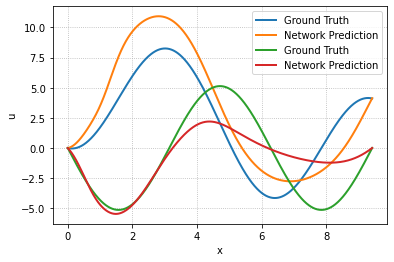

In [8]:
x_test = torch.linspace(0, 3*pi, 10000).reshape(-1,1)
t_test = 4*torch.ones((10000,1))
test = torch.cat([x_test, t_test],1)
u_test = exact_solution_u(x_test, t_test).reshape(-1,1)
p_test = exact_solution_p(x_test, t_test).reshape(-1,1)
my_network = my_network.cpu()
w_test_pred = my_network(test)
u_test_pred = w_test_pred[:,0].reshape(-1,1)
p_test_pred = w_test_pred[:,1].reshape(-1,1)

plt.grid(True, which="both", ls=":")
plt.plot(x_test, u_test, label="Ground Truth",lw=2)
plt.plot(x_test, u_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((u_test_pred - u_test)**2)/torch.mean(u_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")

plt.grid(True, which="both", ls=":")
plt.plot(x_test, p_test, label="Ground Truth",lw=2)
plt.plot(x_test, p_test_pred.detach(), label="Network Prediction",lw=2)
plt.xlabel("x")
plt.ylabel("u")
plt.legend()

# Compute the relative L2 error norm (generalization error)
relative_error_test = torch.mean((p_test_pred - p_test)**2)/torch.mean(p_test**2)
#relative_error_test = torch.max(torch.abs(u_test_pred -u_test))/torch.max(torch.abs(u_test))
print("Relative Error Test: ", relative_error_test.detach().numpy()*100, "%")